<a href="https://colab.research.google.com/github/srinivasanibmbangalore/OpenCVDeepLearningCertification/blob/master/Simple_Panorama.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Multiple computer vision techniques are involved in creating a simple panorama. While a lot more goes into creating a good panorama, the basic principle is to align the concerned images using a homography and 'stitch'ing them intelligently so that you do not see the seams.

In this piece, we will talk about how to perform image stitching using Python and OpenCV. Given a pair of images that share some common region, our goal is to “stitch” them and create a panoramic image scene.

Techniques used include
1.Keypoint detection
2.Local invariant descriptors (SIFT, SURF, etc)
2.Feature matching
4.Homography estimation using RANSAC
5.Perspective warping

Given a pair of images like the ones above, we want to stitch them to create a panoramic scene. It is important to note that both images need to share some common region.
Moreover, our solution has to be robust even if the pictures have differences in one or more of the following aspects:
Scaling
Angle
Spacial position
Capturing devices

The technique we will use is often called “feature based” image alignment because in this technique a sparse set of features are detected in one image and matched with the features in the other image. A transformation ( Homography ) is then calculated based on these matched features that warps one image on to the other. We have already seen in the previous chapter how we can use Homography between two images to align one image w.r.t another.

Once, the second image is aligned with respect to the first image, we can simply stitch the first image with the aligned second image to get a Panorama.

In [1]:
import argparse
import os
import shutil
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/ml_data/OpenCVCertification/images'
imgPath=root_path+"/bldg1.png"
imgPath1=root_path+"/bldg2.png"

Mounted at /content/gdrive


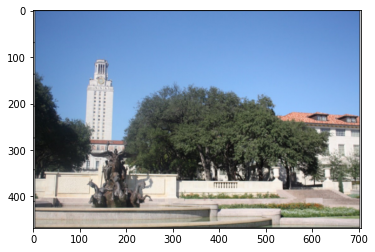

In [3]:
im1 = cv2.imread(imgPath,1)
if (im1.any() == None):
  print("Empty Image")
plt.imshow(im1[...,::-1])

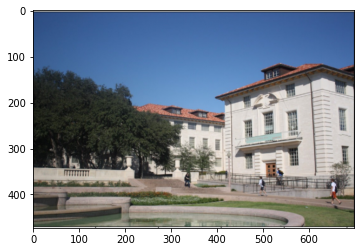

In [4]:
im2 = cv2.imread(imgPath1,1)
if (im2.any() == None):
  print("Empty Image")
plt.imshow(im2[...,::-1])

An initial and probably naive approach would be to extract key points using an algorithm such as Harris Corners. Then, we could try to match the corresponding key points based on some measure of similarity like Euclidean or Hamming distance. As we know, corners have one nice property: they are invariant to rotation. It means that, once we detect a corner, if we rotate an image, that corner will still be there.
***However, what if we rotate then scale an image? In this situation, we would have a hard time because corners are not invariant to scale. That is to say, if we zoom-in to an image, the previously detected corner might become a line!***
In summary, we need features that are invariant to rotation and scaling. That is where more robust methods like  ORB come in.

Methods like ORB try to address the limitations of corner detection algorithms. Usually, corner detector algorithms use a fixed size kernel to detect regions of interest (corners) on images. It is easy to see that when we scale an image, this kernel might become too small or too big.

#Feature Detection and Extraction

In [5]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

In [6]:
# Convert images to grayscale
im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

In [7]:
# Detect ORB features and compute descriptors.
orb = cv2.ORB_create(MAX_FEATURES)
keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

Saving Image with Keypoints


Text(0.5, 1.0, 'Keypoints obtained from the ORB detector')

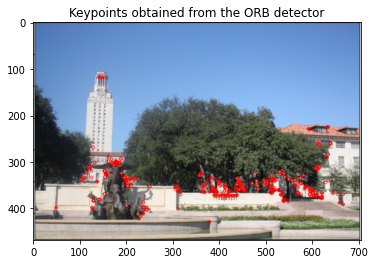

In [8]:
im1Keypoints = np.array([])
im1Keypoints = cv2.drawKeypoints(im1, keypoints1, im1Keypoints, color=(0,0,255),flags=0)
print("Saving Image with Keypoints")
cv2.imwrite("keypoints.jpg", im1Keypoints)
plt.imshow(im1Keypoints[:,:,::-1])
plt.title("Keypoints obtained from the ORB detector")

Saving Image with Keypoints


Text(0.5, 1.0, 'Keypoints obtained from the ORB detector')

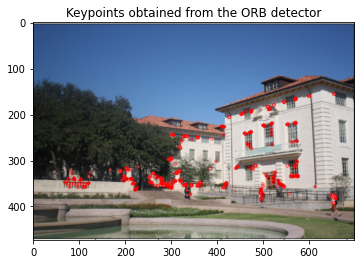

In [9]:
im2Keypoints = np.array([])
im2Keypoints = cv2.drawKeypoints(im2, keypoints2, im2Keypoints, color=(0,0,255),flags=0)
print("Saving Image with Keypoints")
cv2.imwrite("keypoints1.jpg", im2Keypoints)
plt.imshow(im2Keypoints[:,:,::-1])
plt.title("Keypoints obtained from the ORB detector")

Step 2 : Find matching corresponding points
The homography that relates the two images can be calculated only if we know corresponding features in the two images. So a matching algorithm is used to find which features in one image match features in the other image. For this purpose, the descriptor of every feature in one image is compared to the descriptor of every feature in the second image to find good matches. We use hamming distance as a measure of similarity.

It should be noted that we have many incorrect matches and thefore we will need to use a robust method to calculate homography.

 the Matcher algorithm will give us the best (more similar) set of features from both images. Now, we need to take these points and find the transformation matrix that will stitch the 2 images together based on their matching points.
Such a transformation is called the Homography matrix. Briefly, the homography is a 3x3 matrix that can be used in many applications such as camera pose estimation, perspective correction, and image stitching. The Homography is a 2D transformation. It maps points from one plane (image) to another. Let’s see how we get it.

In [11]:
# Match features.
matcher = cv2.DescriptorMatcher_create(
                cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(descriptors1, descriptors2, None)

# Sort matches by score
matches.sort(key=lambda x: x.distance, reverse=False)

# Remove not so good matches
numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
matches = matches[:numGoodMatches]

# Draw top matches
imMatches = cv2.drawMatches(im1, keypoints1,
                            im2, keypoints2, 
                            matches, None)

Text(0.5, 1.0, 'Matchings obtained from the descriptor matcher')

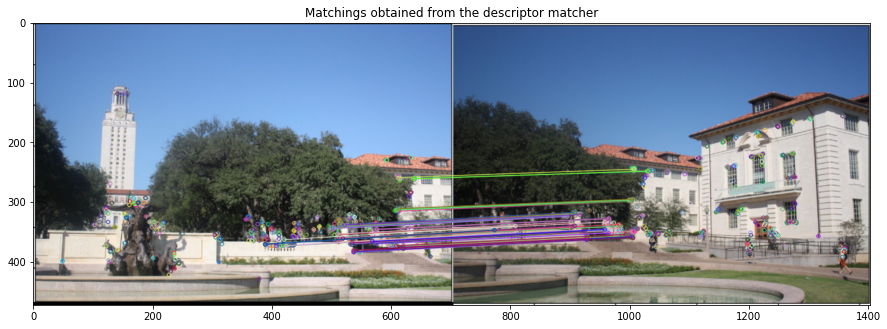

In [12]:
plt.figure(figsize=[15,10])
plt.imshow(imMatches[:,:,::-1])
plt.title("Matchings obtained from the descriptor matcher")

#Step 3 : Image Alignment using Homography

After matching is done, the output ( matches ) has the following attributes :

matches.distance - Distance between descriptors. Should be lower for better match.
matches.trainIdx - Index of the descriptor in train descriptors
matches.queryIdx - Index of the descriptor in query descriptors
matches.imgIdx - Index of the train image.
To simplify things, the queryIdx corresponds to points in image1 and trainIdx corresponds to points in image2. We will create two lists - points1 and points2 from the matching points which will serve as the final set of correspoding points to be used in the findHomography function.

In [20]:
points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

# Find homography
h, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

'''
RANdom SAmple Consensus or RANSAC is an iterative algorithm 
to fit linear models. Different from other linear regressors, 
RANSAC is designed to be robust to outliers.
On the contrary, RANSAC only fits the model on the subset of points identified as the inliers.
This characteristic is very important to our use case. Here, we are going to 
use RANSAC to estimate the Homography matrix. It turns out that the Homography 
is very sensitive to the quality of data we pass to it. Hence, it is important 
to have an algorithm (RANSAC) that can filter points 
that clearly belong to the data distribution from the ones which do not.
'''
print("Homograhy matrix \n{}".format(h))

Homograhy matrix 
[[ 5.57358187e-01 -7.31950649e-02  3.38420654e+02]
 [-2.00221491e-01  7.36772287e-01  8.73545360e+01]
 [-4.85171718e-04 -2.26837990e-04  1.00000000e+00]]


Once we have the estimated Homography, we need to warp one of the images to a common plane.
Here, we are going to apply a perspective transformation to one of the images. Basically, a perspective transform may combine one or more operations like rotation, scale, translation, or shear. The idea is to transform one of the images so that both images merge as one. To do this, we can use the OpenCV warpPerspective() function. It takes an image and the homography as input. Then, it warps the source image to the destination based on the homography.

Text(0.5, 1.0, 'Second image aligned to first image obtained using homography and warping')

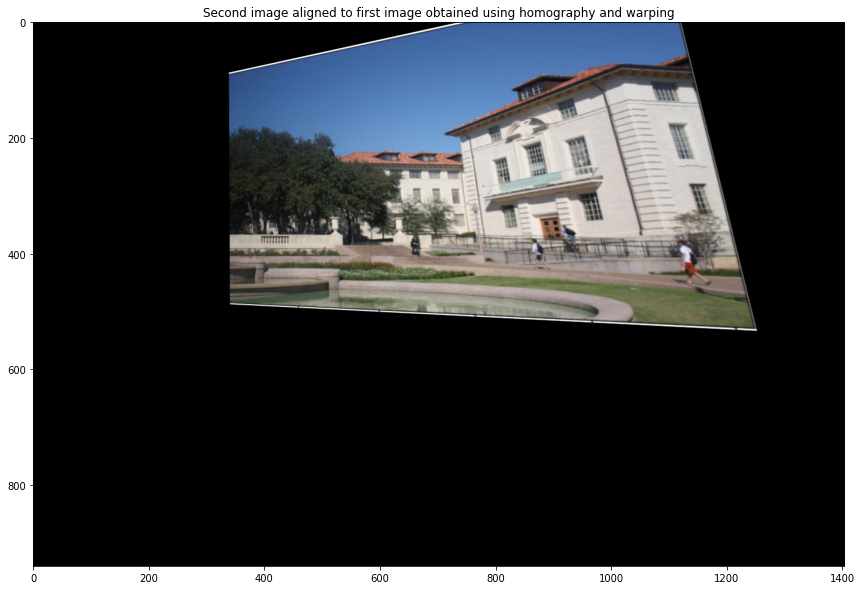

In [22]:
'''
While using the warp function, we should specify a different size of the 
output image(not the default size). Since we are stitching the images horizontally,
 we should specify the width of the output image to 
be sum of both images. We can keep the height to be same as any one of them.
'''

# Use homography
im1Height, im1Width, channels = im1.shape
im2Height, im2Width, channels = im2.shape

im2Aligned = cv2.warpPerspective(im2, h, 
                            (im2Width + im1Width, im1Height+im2Height))
plt.figure(figsize=[15,10])
plt.imshow(im2Aligned[:,:,::-1])
plt.title("Second image aligned to first image obtained using homography and warping")

Text(0.5, 1.0, 'Final Stitched Image')

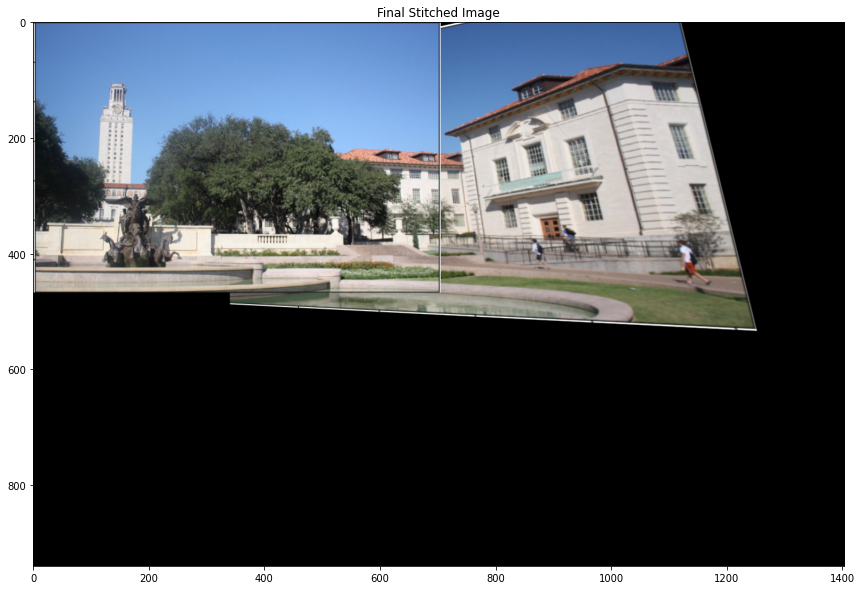

In [23]:
# Stitch Image 1 with aligned image 2
stitchedImage = np.copy(im2Aligned)
stitchedImage[0:im1Height,0:im1Width] = im1
plt.figure(figsize=[15,10])
plt.imshow(stitchedImage[:,:,::-1])
plt.title("Final Stitched Image")

Conclusion
This approach has some challenges :

There might be visible seams at the boundary of the two images. This is because of the variation in lighting / exposure between the two images.
The lighting variation might also require some color correction as the two images might not blend well after stitching.
Difficult to extend to multiple images.
OpenCV has some utilities for creating Panoramas from a set of images. You will use it to create a panorama in the next assignment.